In [1]:
"""import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

import kagglehub

# Download latest version
path = kagglehub.dataset_download("lexset/synthetic-asl-alphabet")

print("Path to dataset files:", path)"""

'import kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("grassknoted/asl-alphabet")\n\nprint("Path to dataset files:", path)\n\nimport kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("lexset/synthetic-asl-alphabet")\n\nprint("Path to dataset files:", path)'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import time
import itertools
import os

from PIL import Image

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader,  random_split
from torch.nn.parallel import DataParallel
from tqdm import tqdm

import torchvision
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchmetrics
from tqdm.notebook import tqdm

In [2]:
train_data = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_data = "/kaggle/input/synthetic-asl-alphabet/Train_Alphabet"

In [4]:

class_names = []
image_counts = []

for folder in os.listdir(train_data):
    folder_path = os.path.join(train_data, folder)
    if os.path.isdir(folder_path):  # sadece klasörleri al
        class_names.append(folder)
        image_counts.append(len(os.listdir(folder_path)))

df = pd.DataFrame({
    "Sınıf": class_names,
    "Adet": image_counts
})


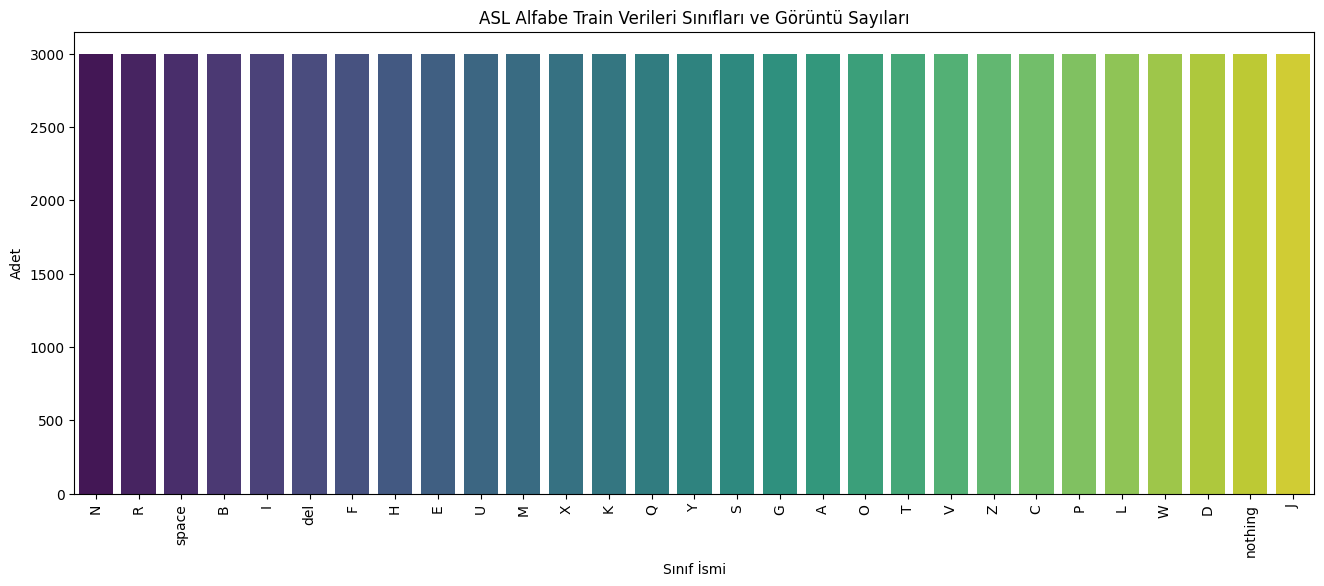

In [5]:

plt.figure(figsize=(16, 6))
sns.barplot(x="Sınıf", y="Adet", data=df, palette="viridis")

plt.xticks(rotation=90)
plt.title("ASL Alfabe Train Verileri Sınıfları ve Görüntü Sayıları")
plt.xlabel("Sınıf İsmi")
plt.ylabel("Adet")
plt.show()

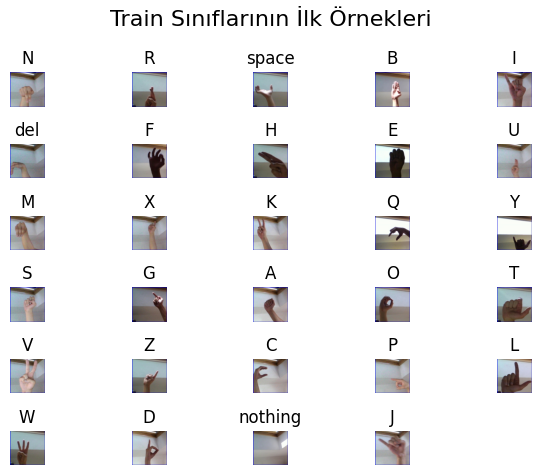

In [6]:
for i, class_name in enumerate(class_names[:]):
    folder_path = os.path.join(train_data, class_name)
    
    files = os.listdir(folder_path)
    if len(files) == 0:
        continue
        
    first_image_path = os.path.join(folder_path, files[0])

    img = mpimg.imread(first_image_path)
    
    plt.subplot(6, 5, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.suptitle("Train Sınıflarının İlk Örnekleri", fontsize=16)
plt.tight_layout()
plt.show()

In [7]:

class_names = []
image_counts = []

for folder in os.listdir(test_data):
    folder_path = os.path.join(test_data, folder)
    if os.path.isdir(folder_path):  # sadece klasörleri al
        class_names.append(folder)
        image_counts.append(len(os.listdir(folder_path)))


df = pd.DataFrame({
    "Sınıf": class_names,
    "Adet": image_counts
})


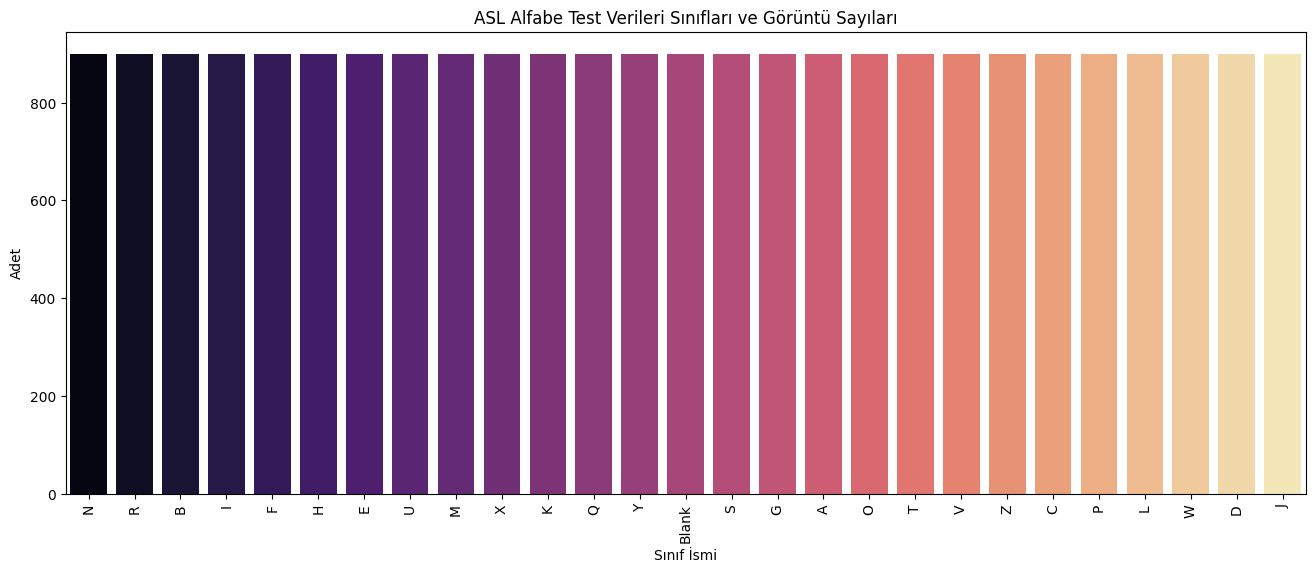

In [8]:

plt.figure(figsize=(16, 6))
sns.barplot(x="Sınıf", y="Adet", data=df, palette="magma")

plt.xticks(rotation=90)
plt.title("ASL Alfabe Test Verileri Sınıfları ve Görüntü Sayıları")
plt.xlabel("Sınıf İsmi")
plt.ylabel("Adet")
plt.show()

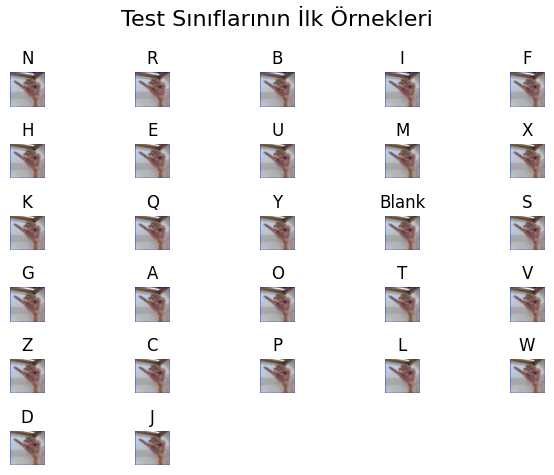

In [9]:
for i, class_name in enumerate(class_names[:]):
    folder_path = os.path.join(test_data, class_name)
    
    files = os.listdir(folder_path)
    if len(files) == 0:
        continue
        
    first_imag_path = os.path.join(folder_path, files[0])

    img = mpimg.imread(first_image_path)
    
    plt.subplot(6, 5, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.suptitle("Test Sınıflarının İlk Örnekleri", fontsize=16)
plt.tight_layout()
plt.show()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
batch_size = 128
valid_size = 0.2
num_epochs = 20
num_workers = 4
lr = [0.01,0.001,0.005,0.0001]

In [4]:
transform  = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
)

In [7]:

dataset = datasets.ImageFolder(
    root= train_data,
    transform=transform
)

val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = num_workers)

In [22]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
test_dataset = datasets.ImageFolder(
    root = test_data,
    transform = test_transform
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers= num_workers)

In [15]:
print(f"train shape: {train_dataset[1][0].shape}")
print(f"valid shape: {val_dataset[1][0].shape}")
print(f"test shape: {test_dataset[1][0].shape}")

train shape: torch.Size([3, 200, 200])
valid shape: torch.Size([3, 200, 200])
test shape: torch.Size([3, 512, 513])


In [9]:

class NetCustom(nn.Module):
    def __init__(self, conv_filters=[32,64,128], dense_sizes=[256,128], dropout_rate=0.3, num_classes=29):
        super(NetCustom, self).__init__()
        # Conv katmanlarını dinamik oluştur
        self.convs = nn.ModuleList()
        in_channels = 3
        for out_channels in conv_filters:
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
            )
            self.convs.append(block)
            in_channels = out_channels
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4,4))
        
        # Dense katmanlarını dinamik oluştur
        fc_in = conv_filters[-1]*4*4
        self.fcs = nn.ModuleList()
        for fc_out in dense_sizes:
            self.fcs.append(nn.Linear(fc_in, fc_out))
            fc_in = fc_out
        
        self.fc_out = nn.Linear(fc_in, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        for fc in self.fcs:
            x = self.dropout(F.relu(fc(x)))
        x = self.fc_out(x)
        return x


In [11]:
conv_filters_options = [[32,64],[32,64,128]] 
dense_sizes_options = [[128],[256,128]] 
dropouts_options = [0.3]
learning_rates_options = [1e-3,1e-4] 
batch_sizes_options = [64,128] 
results = []

In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

grid_combinations = list(itertools.product(
    conv_filters_options, dense_sizes_options, dropouts_options, learning_rates_options, batch_sizes_options
))

outer_bar = tqdm(grid_combinations, desc="Grid Search")

for conv_filters, dense_sizes, dropout_rate, lr, batch_size in outer_bar:
    start_time = time.time()
    # Model tanımı
    model = NetCustom(conv_filters=conv_filters,
                      dense_sizes=dense_sizes,
                      dropout_rate=dropout_rate,
                      num_classes=29)

    # Multi-GPU
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
   
    # Epoch loop (print kullanımı)
    for epoch in range(3):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        train_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
 
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loader_tqdm.set_postfix({'loss': loss.item()})
        # Notebook için tqdm.write yerine print
        print(f"Conv:{conv_filters}, Dense:{dense_sizes}, Dropout:{dropout_rate}, LR:{lr}, Batch:{batch_size} | Epoch {epoch+1} Loss: {running_loss/len(val_loader):.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total

    results.append({
        "conv_filters": conv_filters,
        "dense_sizes": dense_sizes,
        "dropout": dropout_rate,
        "lr": lr,
        "batch_size": batch_size,
        "val_acc": val_acc
    })

    outer_bar.set_postfix({"val_acc": f"{val_acc:.4f}"})


Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 1 Loss: 2.9910


Epoch 2/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 2 Loss: 2.5009


Epoch 3/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 3 Loss: 2.2639


Epoch 1/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 1 Loss: 3.0514


Epoch 2/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 2 Loss: 2.5694


Epoch 3/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 3 Loss: 2.3005


Epoch 1/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 1 Loss: 3.2486


Epoch 2/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 2 Loss: 2.9837


Epoch 3/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 3 Loss: 2.7776


Epoch 1/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 1 Loss: 3.2954


Epoch 2/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 2 Loss: 3.1025


Epoch 3/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 3 Loss: 2.9200


Epoch 1/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 1 Loss: 2.9389


Epoch 2/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 2 Loss: 2.3668


Epoch 3/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 3 Loss: 2.0645


Epoch 1/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 1 Loss: 3.0761


Epoch 2/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 2 Loss: 2.5638


Epoch 3/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 3 Loss: 2.2357


Epoch 1/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 1 Loss: 3.2923


Epoch 2/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 2 Loss: 3.0014


Epoch 3/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 3 Loss: 2.7784


Epoch 1/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 1 Loss: 3.3425


Epoch 2/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 2 Loss: 3.1878


Epoch 3/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 3 Loss: 2.9466


Epoch 1/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 1 Loss: 2.9366


Epoch 2/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 2 Loss: 2.3180


Epoch 3/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 3 Loss: 1.9850


Epoch 1/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 1 Loss: 2.9760


Epoch 2/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 2 Loss: 2.2730


Epoch 3/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 3 Loss: 1.9116


Epoch 1/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 1 Loss: 3.2053


Epoch 2/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 2 Loss: 2.8119


Epoch 3/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 3 Loss: 2.4770


Epoch 1/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 1 Loss: 3.2181


Epoch 2/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 2 Loss: 2.8888


Epoch 3/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 3 Loss: 2.5972


Epoch 1/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 1 Loss: 3.0024


Epoch 2/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 2 Loss: 2.2695


Epoch 3/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:64 | Epoch 3 Loss: 1.8223


Epoch 1/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 1 Loss: 3.0115


Epoch 2/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 2 Loss: 2.3804


Epoch 3/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.001, Batch:128 | Epoch 3 Loss: 1.8367


Epoch 1/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 1 Loss: 3.2581


Epoch 2/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 2 Loss: 2.8546


Epoch 3/20 [Train]:   0%|          | 0/272 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:64 | Epoch 3 Loss: 2.4998


Epoch 1/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 1 Loss: 3.3037


Epoch 2/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 2 Loss: 3.0068


Epoch 3/20 [Train]:   0%|          | 0/136 [00:00<?, ?it/s]

Conv:[32, 64, 128], Dense:[256, 128], Dropout:0.3, LR:0.0001, Batch:128 | Epoch 3 Loss: 2.7209


In [21]:
# Tüm sonuçları tabloya dök
df_results = pd.DataFrame(results)
print(df_results.sort_values("val_acc", ascending=False).head(10))

# En iyi sonucu ayrıca yazdır
best = df_results.loc[df_results["val_acc"].idxmax()]
print("\n🔥 En iyi hiperparametreler:")
print(best.to_dict())

     conv_filters dense_sizes  dropout      lr  batch_size   val_acc
13  [32, 64, 128]  [256, 128]      0.3  0.0010         128  0.534828
12  [32, 64, 128]  [256, 128]      0.3  0.0010          64  0.527299
9   [32, 64, 128]       [128]      0.3  0.0010         128  0.497069
8   [32, 64, 128]       [128]      0.3  0.0010          64  0.430517
4        [32, 64]  [256, 128]      0.3  0.0010          64  0.402299
10  [32, 64, 128]       [128]      0.3  0.0001          64  0.392816
0        [32, 64]       [128]      0.3  0.0010          64  0.385287
5        [32, 64]  [256, 128]      0.3  0.0010         128  0.361494
14  [32, 64, 128]  [256, 128]      0.3  0.0001          64  0.361149
11  [32, 64, 128]       [128]      0.3  0.0001         128  0.359828

🔥 En iyi hiperparametreler:
{'conv_filters': [32, 64, 128], 'dense_sizes': [256, 128], 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128, 'val_acc': 0.5348275862068965}


In [14]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




start_time = time.time()
# Model tanımı
model = NetCustom(conv_filters=[32, 64, 128],
                      dense_sizes=[256, 128],
                      num_classes=29)

    # Multi-GPU
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

    # DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=128, num_workers=4, pin_memory=True)
   
for epoch in range(10):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
 
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader_tqdm.set_postfix({'loss': loss.item()})
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct = 0
    val_loss = 0.0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)   # <--- BURADA ekle
            val_loss += loss.item()
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total

    tqdm.write(f"Epoch {epoch+1}/{num_epochs} | "
               f"Train Loss: {train_loss:.4f} | "
               f"Val Loss: {val_loss:.4f} | "
               f"Val Acc: {val_acc:.4f}")


Epoch 1/20 [Train]:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 2.7081 | Val Loss: 1.9885 | Val Acc: 0.3369


Epoch 2/20 [Train]:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 1.9481 | Val Loss: 1.5439 | Val Acc: 0.4578


Epoch 3/20 [Train]:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 1.4417 | Val Loss: 1.0224 | Val Acc: 0.6399


Epoch 5/20 [Train]:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 1.2931 | Val Loss: 0.8568 | Val Acc: 0.6906


Epoch 6/20 [Train]:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 1.1861 | Val Loss: 0.7262 | Val Acc: 0.7491


Epoch 7/20 [Train]:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 1.1048 | Val Loss: 0.6502 | Val Acc: 0.7855


Epoch 8/20 [Train]:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 1.0326 | Val Loss: 0.6172 | Val Acc: 0.7925


Epoch 9/20 [Train]:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.9672 | Val Loss: 0.5811 | Val Acc: 0.8010


Epoch 10/20 [Train]:   0%|          | 0/544 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.9170 | Val Loss: 0.5851 | Val Acc: 0.7974


In [16]:
 torch.save(model.state_dict(), 'asl_alphabet.pt')

In [18]:
for data, target in train_loader:
    output = model(data)
    print("Output shape:", output.shape)
    print("Target shape:", target.shape)
    break

Output shape: torch.Size([128, 29])
Target shape: torch.Size([128])


In [19]:
model.load_state_dict(torch.load('asl_alphabet.pt'))
print('Finished Training')

test_loss = 0.0
class_correct = [0] * 10
class_total = [0] * 10

Finished Training


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Test ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Hesaplamalar
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="weighted")
rec  = recall_score(all_labels, all_preds, average="weighted")
f1   = f1_score(all_labels, all_preds, average="weighted")

print(f"Test Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1 Score : {f1:.4f}")


Test Accuracy : 0.8013
Test Precision: 0.8154
Test Recall   : 0.8013
Test F1 Score : 0.7978
